# Получение значений метрик

In [1]:
import time
import timeit
from IPython import display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.mixture import GaussianMixture
from modelgym.utils import XYCDataset
from modelgym.models import XGBClassifier
from itertools import cycle, islice
import h5py 
import shutil
import json

import sys
sys.path.append('../../../')

from evaluation import *
from tqdm import tqdm
from math import ceil
np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.4 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Подготовим данные

In [2]:
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../../SUSY.csv', header=None, names=column_names)

In [3]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [4]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [5]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

Балансировка классов

In [6]:
min_class_size = min(X_data[np.where(labels==0)[0]].shape[0], X_data[np.where(labels==1)[0]].shape[0])

X_0 = X_data[np.where(labels==0)[0]]
X_1 = X_data[np.where(labels==1)[0]]

X_data = np.concatenate((X_0[:min_class_size], X_1[:min_class_size]))
labels = np.concatenate((np.zeros((min_class_size,1)), np.ones((min_class_size,1)))).ravel()

Разбиваем на train(8% от всех данных) и test(2%)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=8e-2, test_size=2e-2, random_state=5)

In [9]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

Разбиваем объекты по классам

In [10]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [11]:
X_good.shape, X_train.shape, X_data.shape

((183026, 18), (366052, 18), (4575654, 18))

In [12]:
import pickle
import numpy as np

from modelgym.models import Model, LearningTask
from hyperopt import hp
from hyperopt.pyll.base import scope

from sklearn.ensemble import IsolationForest

In [13]:
X_train.shape[1]

18

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [15]:
def sigmoid(x):
    """Compute sigmoid values for each sets of scores in x."""
    return 1 / (1 + np.exp(-x))

In [16]:
a = np.array([1, 2, 3])
np.concatenate([a, a], axis=0)

array([1, 2, 3, 1, 2, 3])

In [17]:
class IsolationForestClassifier(Model):
    def __init__(self, params=None):
        """
        Args:
            params (dict): parameters for model.
        """

        if params is None:
            params = {}

        self.params = {
            'n_estimators': 10,
            'max_samples': 0.1, 
            'contamination': 0.007,
            'verbose': 0,
        }
        if params:
            self.params.update(params)
            
        self.model = None

    def _set_model(self, model):
        """
        sets new model, internal method, do not use
        Args:
            model: internal model
        """
        self.model = model

    def _convert_to_dataset(self, data, label=None, cat_cols=None):
        return XYCDataset(data, label, cat_cols)

    def fit(self, dataset, weights=None):
        """
        Args:
            X (np.array, shape (n_samples, n_features)): the input data
            y (np.array, shape (n_samples, ) or (n_samples, n_outputs)): the target data
            weights (np.array, shape (n_samples, ) or (n_samples, n_outputs) or None): weights of the data
        Return:
            self
        """
        # log info
        print('*****************')
        print(self.params)
        
        # clean train set
        idx_pos = np.where(dataset.y==1)[0]
        idx_neg = np.random.permutation(np.where(dataset.y!=1)[0])
        end_ind = int(self.params['contamination'] * idx_neg.shape[0])
        idx = np.concatenate([idx_pos, idx_neg[:end_ind]], axis=0)
        dtrain = self._convert_to_dataset(dataset.X[idx], dataset.y[idx])
        
        # fit
        start_time = timeit.default_timer()
        self.model = IsolationForest(
            random_state=self.params.get('random_state', 5), **self.params
        ).fit(dtrain.X, dtrain.y)
        run_time = timeit.default_timer() - start_time
        
        # log info
        print('Fitted')
        print("Run time: {:.2f} sec".format(run_time))
        print('*****************\n')
        return self

    def save_snapshot(self, filename):
        """
        Return:
            serializable internal model state snapshot.
        """
        assert self.model is not None, "model is not fitted"
        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)

    @staticmethod
    def load_from_snapshot(self, filename):
        """
        :snapshot serializable internal model state
        loads from serializable internal model state snapshot.
        """
        with open(filename, 'rb') as f:
            model = pickle.load(f)

        new_model = IsolationForestClassifier(model.get_params())
        new_model._set_model(model)
        return new_model

    def predict(self, dataset):
        """
        Args:
            X (np.array, shape (n_samples, n_features)): the input data
        Return:
            np.array, shape (n_samples, ) or (n_samples, n_outputs)
        """
        return self.model.predict(dataset.X)

    def is_possible_predict_proba(self):
        """
        Return:
            bool, whether model can predict proba
        """
        return True

    def predict_proba(self, dataset):
        """
        Args:
            X (np.array, shape (n_samples, n_features)): the input data
        Return:
            np.array, shape (n_samples, n_classes)
        """
        assert self.is_possible_predict_proba(), "Model cannot predict probability distribution"
        return self.model.decision_function(dataset.X)
#         return sigmoid(-self.model.decision_function(dataset.X)) # WHY '-'?!!!!!

    @staticmethod
    def get_default_parameter_space():
        """
        Return:
            dict of DistributionWrappers
        """

        return {
#             'max_features': hp.uniform('max_features', 0.2, 1),
            'n_estimators': scope.int(hp.quniform('n_estimators', 100, 2000, 200)),
            'max_samples': hp.uniform('max_samples', 0.1, 1), 
            'contamination': hp.loguniform('contamination', -5, 0),
        }

    @staticmethod
    def get_learning_task():
        return LearningTask.CLASSIFICATION

## Подберем IsolationForest с оптимальными параметрами

In [18]:
from modelgym.trainers import TpeTrainer
from skopt.optimizer import forest_minimize, gp_minimize
from modelgym.metrics import Accuracy, RocAuc, F1
from modelgym.report import Report

Создаем классификатор и trainer для подбора оптимальных параметров

In [19]:
models = [IsolationForestClassifier]
trainer = TpeTrainer(models)

Обертка для данных

In [20]:
y_train_rescale = np.where(y_train == 0, np.ones((y_train.shape)), -np.ones((y_train.shape)))

In [21]:
dataset = XYCDataset(X_train, y_train_rescale)

Сам подбор параметров

In [22]:
%%time
trainer.crossval_optimize_params(RocAuc(), dataset, metrics=[Accuracy(), RocAuc(), F1()])

*****************
{'n_estimators': 1600, 'max_samples': 0.5171464826467033, 'contamination': 0.06063114230026169, 'verbose': 0}
Fitted
Run time: 303.21 sec
*****************

*****************
{'n_estimators': 1600, 'max_samples': 0.5171464826467033, 'contamination': 0.06063114230026169, 'verbose': 0}
Fitted
Run time: 304.39 sec
*****************

*****************
{'n_estimators': 1600, 'max_samples': 0.5171464826467033, 'contamination': 0.06063114230026169, 'verbose': 0}
Fitted
Run time: 304.94 sec
*****************

*****************
{'n_estimators': 1400, 'max_samples': 0.6913740249438012, 'contamination': 0.7852030480629357, 'verbose': 0}
Fitted
Run time: 507.87 sec
*****************

*****************
{'n_estimators': 1400, 'max_samples': 0.6913740249438012, 'contamination': 0.7852030480629357, 'verbose': 0}
Fitted
Run time: 504.85 sec
*****************

*****************
{'n_estimators': 1400, 'max_samples': 0.6913740249438012, 'contamination': 0.7852030480629357, 'verbose': 0}


*****************
{'n_estimators': 1800, 'max_samples': 0.3776315764188969, 'contamination': 0.6962424193880082, 'verbose': 0}
Fitted
Run time: 554.31 sec
*****************

*****************
{'n_estimators': 600, 'max_samples': 0.547227069615814, 'contamination': 0.08979321208070809, 'verbose': 0}
Fitted
Run time: 112.19 sec
*****************

*****************
{'n_estimators': 600, 'max_samples': 0.547227069615814, 'contamination': 0.08979321208070809, 'verbose': 0}
Fitted
Run time: 108.91 sec
*****************

*****************
{'n_estimators': 600, 'max_samples': 0.547227069615814, 'contamination': 0.08979321208070809, 'verbose': 0}
Fitted
Run time: 111.29 sec
*****************

*****************
{'n_estimators': 2000, 'max_samples': 0.8356265134812865, 'contamination': 0.3944477159978967, 'verbose': 0}
Fitted
Run time: 564.65 sec
*****************

*****************
{'n_estimators': 2000, 'max_samples': 0.8356265134812865, 'contamination': 0.3944477159978967, 'verbose': 0}
Fitted

*****************
{'n_estimators': 1400, 'max_samples': 0.6119677462954969, 'contamination': 0.028317802035653986, 'verbose': 0}
Fitted
Run time: 256.18 sec
*****************

*****************
{'n_estimators': 1400, 'max_samples': 0.6119677462954969, 'contamination': 0.028317802035653986, 'verbose': 0}
Fitted
Run time: 261.79 sec
*****************

*****************
{'n_estimators': 1000, 'max_samples': 0.7047962109797282, 'contamination': 0.24141596611403734, 'verbose': 0}
Fitted
Run time: 214.74 sec
*****************

*****************
{'n_estimators': 1000, 'max_samples': 0.7047962109797282, 'contamination': 0.24141596611403734, 'verbose': 0}
Fitted
Run time: 220.73 sec
*****************

*****************
{'n_estimators': 1000, 'max_samples': 0.7047962109797282, 'contamination': 0.24141596611403734, 'verbose': 0}
Fitted
Run time: 222.03 sec
*****************

*****************
{'n_estimators': 1600, 'max_samples': 0.5104882599423564, 'contamination': 0.009751876734438886, 'verbose

Fitted
Run time: 282.81 sec
*****************

*****************
{'n_estimators': 1200, 'max_samples': 0.28749709761011044, 'contamination': 0.07617518882933227, 'verbose': 0}
Fitted
Run time: 210.72 sec
*****************

*****************
{'n_estimators': 1200, 'max_samples': 0.28749709761011044, 'contamination': 0.07617518882933227, 'verbose': 0}
Fitted
Run time: 209.49 sec
*****************

*****************
{'n_estimators': 1200, 'max_samples': 0.28749709761011044, 'contamination': 0.07617518882933227, 'verbose': 0}
Fitted
Run time: 205.55 sec
*****************

*****************
{'n_estimators': 1800, 'max_samples': 0.3761155370042712, 'contamination': 0.30909153439455667, 'verbose': 0}
Fitted
Run time: 402.45 sec
*****************

*****************
{'n_estimators': 1800, 'max_samples': 0.3761155370042712, 'contamination': 0.30909153439455667, 'verbose': 0}
Fitted
Run time: 396.48 sec
*****************

*****************
{'n_estimators': 1800, 'max_samples': 0.3761155370042712,

Результаты

In [23]:
reporter = Report(trainer.get_best_results(), dataset, [Accuracy(), RocAuc(), F1()])

In [24]:
reporter.print_all_metric_results()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                       tuned
IsolationForestClassifier  0.586938 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                       tuned
IsolationForestClassifier  0.763956 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                       tuned
IsolationForestClassifier  0.705948 (+0.00%)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



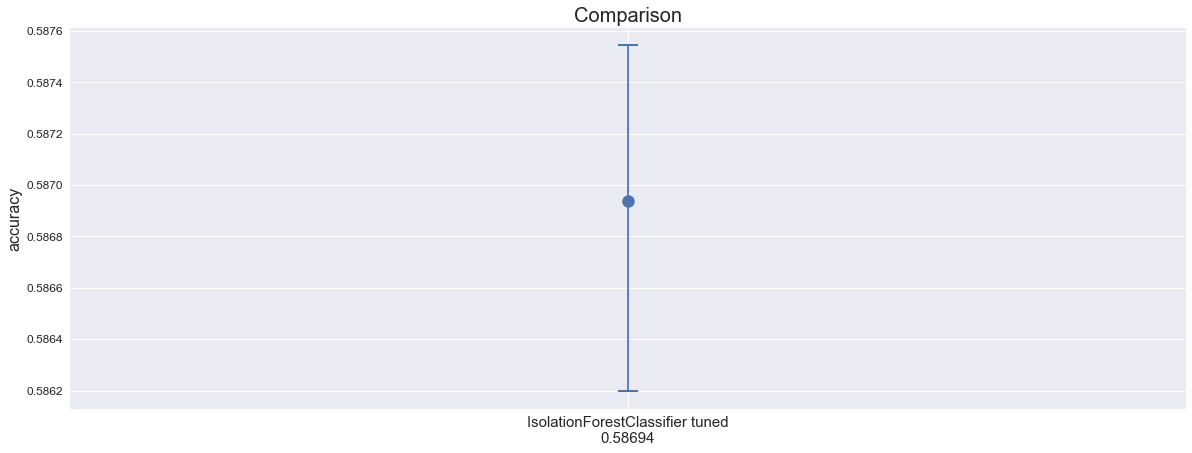


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



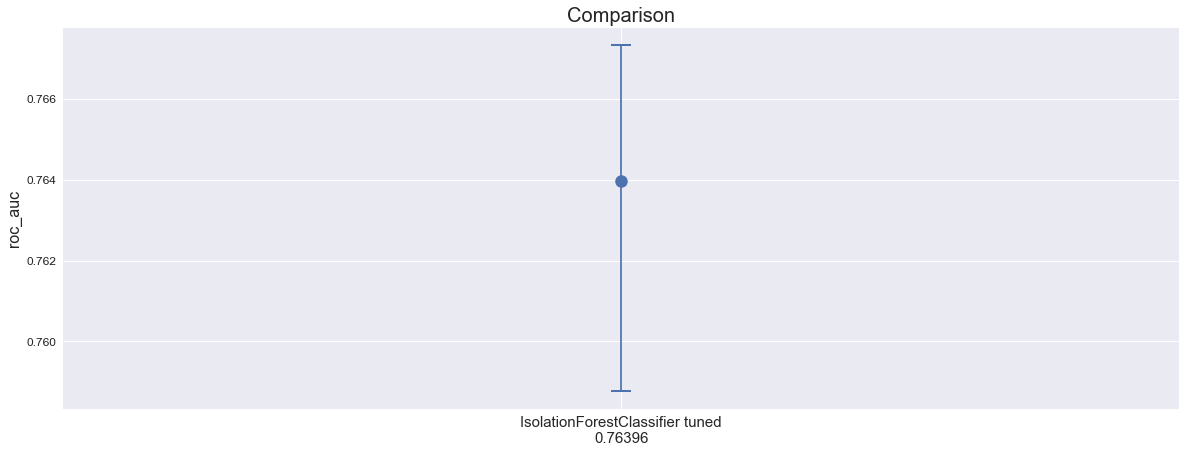


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



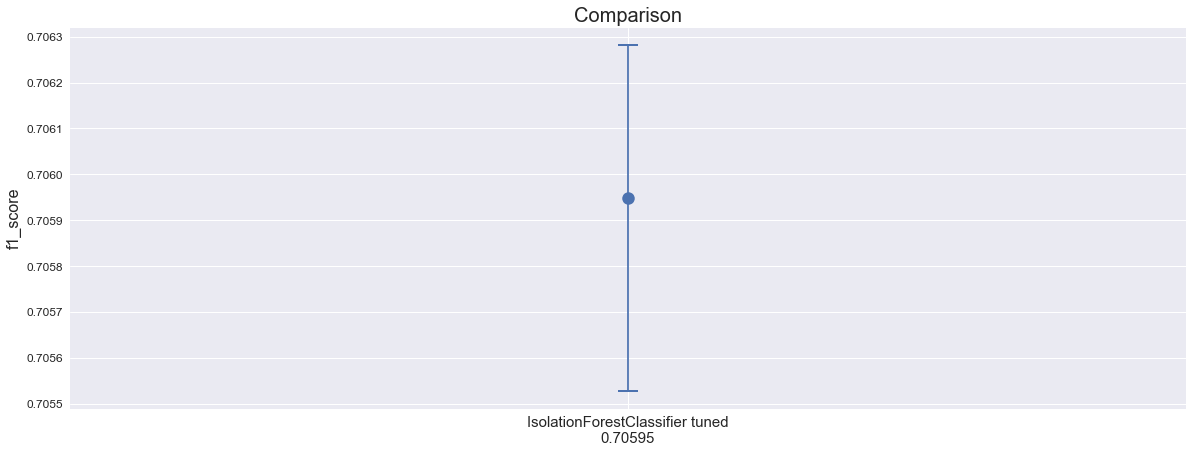

In [25]:
reporter.plot_all_metrics()

Вытащим значения оптимальных параметров

In [26]:
trainer_log = trainer.state['IsolationForestClassifier']

In [27]:
trainer_log.best_trial

{'book_time': datetime.datetime(2018, 6, 7, 21, 27, 49, 195000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'contamination': [49], 'max_samples': [49], 'n_estimators': [49]},
  'tid': 49,
  'vals': {'contamination': [0.009799868586013971],
   'max_samples': [0.22104180795937428],
   'n_estimators': [800.0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 6, 7, 21, 42, 52, 473000),
 'result': {'loss': -0.763955908641709,
  'loss_variance': 0.003721423979906302,
  'metric_cv_results': [{'accuracy': 0.5875444606533462,
    'f1_score': 0.7060355955864743,
    'roc_auc': 0.7587687077338886},
   {'accuracy': 0.5870739323209061,
    'f1_score': 0.7062808240739662,
    'roc_auc': 0.7673197069362827},
   {'accuracy': 0.5861970053353222,
    'f1_score': 0.705528306398465,
    'roc_auc': 0.7657793112549558}],
  'params': {'contamination': 0.009799868586013971,
   'max_samples': 0.22104180795937428,
   'n_estimators': 800},

In [28]:
trainer_log.best_trial

{'book_time': datetime.datetime(2018, 6, 7, 21, 27, 49, 195000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'contamination': [49], 'max_samples': [49], 'n_estimators': [49]},
  'tid': 49,
  'vals': {'contamination': [0.009799868586013971],
   'max_samples': [0.22104180795937428],
   'n_estimators': [800.0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 6, 7, 21, 42, 52, 473000),
 'result': {'loss': -0.763955908641709,
  'loss_variance': 0.003721423979906302,
  'metric_cv_results': [{'accuracy': 0.5875444606533462,
    'f1_score': 0.7060355955864743,
    'roc_auc': 0.7587687077338886},
   {'accuracy': 0.5870739323209061,
    'f1_score': 0.7062808240739662,
    'roc_auc': 0.7673197069362827},
   {'accuracy': 0.5861970053353222,
    'f1_score': 0.705528306398465,
    'roc_auc': 0.7657793112549558}],
  'params': {'contamination': 0.009799868586013971,
   'max_samples': 0.22104180795937428,
   'n_estimators': 800},

In [29]:
trainer_log.best_trial

{'book_time': datetime.datetime(2018, 6, 7, 21, 27, 49, 195000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'contamination': [49], 'max_samples': [49], 'n_estimators': [49]},
  'tid': 49,
  'vals': {'contamination': [0.009799868586013971],
   'max_samples': [0.22104180795937428],
   'n_estimators': [800.0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 6, 7, 21, 42, 52, 473000),
 'result': {'loss': -0.763955908641709,
  'loss_variance': 0.003721423979906302,
  'metric_cv_results': [{'accuracy': 0.5875444606533462,
    'f1_score': 0.7060355955864743,
    'roc_auc': 0.7587687077338886},
   {'accuracy': 0.5870739323209061,
    'f1_score': 0.7062808240739662,
    'roc_auc': 0.7673197069362827},
   {'accuracy': 0.5861970053353222,
    'f1_score': 0.705528306398465,
    'roc_auc': 0.7657793112549558}],
  'params': {'contamination': 0.009799868586013971,
   'max_samples': 0.22104180795937428,
   'n_estimators': 800},

Сами параметры

In [30]:
opt_params = trainer_log.best_trial['result']['params']
opt_params

{'contamination': 0.009799868586013971,
 'max_samples': 0.22104180795937428,
 'n_estimators': 800}

Сохраним эти значения

In [31]:
file_name = 'optimal_isolation_forest_params_3.json'
with open(file_name, 'w', encoding="utf-8") as file:
    # writing
    json.dump(opt_params, file, indent=4, ensure_ascii=False)

Загрузим значения

In [32]:
file_name = 'optimal_isolation_forest_params_3.json'
with open(file_name, 'r', encoding="utf-8") as file:
    opt_params = json.load(file)

In [112]:
opt_params

{'contamination': 0.05385746471924635,
 'max_samples': 0.9251608898029281,
 'n_estimators': 200}

In [82]:
opt_params

{'contamination': 0.05172921173547536,
 'max_samples': 0.13429110246032988,
 'n_estimators': 1400}

In [48]:
opt_params

{'contamination': 0.1029849455683469,
 'max_samples': 0.9940821722848857,
 'n_estimators': 200}

In [33]:
opt_params

{'contamination': 0.009799868586013971,
 'max_samples': 0.22104180795937428,
 'n_estimators': 800}

## Получим значения метрик Isolation Forest при оптимальных параметрах

In [34]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [35]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall

In [36]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [37]:
def _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append((frac, p_at_r(y_test, y_pred, float(recall))))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [(frac, p_at_r(y_test, y_pred, float(recall)))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = (frac, p_at_r(y_test, y_pred, float(recall)))

Сохранение данных

In [38]:
def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json

In [39]:
def create_metrics_folder(metrics_path):
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

In [40]:
def dump_metrics_un(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(unsupervised_pr_aucs, folder, "unsupervised_pr_aucs")
    dump(unsupervised_roc_aucs, folder, "unsupervised_roc_aucs")
    dump(unsupervised_p_at_r, folder, "unsupervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

In [41]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

0it [00:00, ?it/s]

Isolation Forest
recall_score  0.18469305242913653
precision_score  0.9591419816138917
f1_score  0.3097419733176954
confusion_matrix 
[[45397   360]
 [37306  8451]]


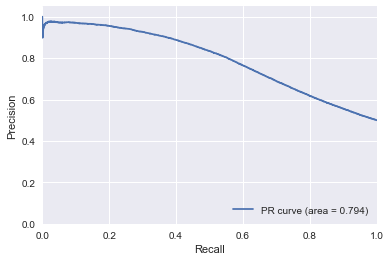

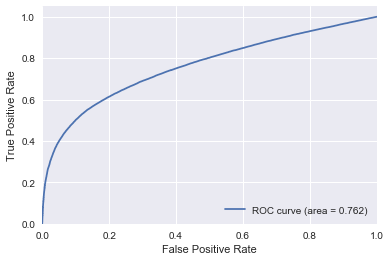

1it [05:19, 319.87s/it]

Precision at recall:  0.8 = [(0, 0.6180964762692691)]; 0.9 = [(0, 0.555527078977541)]; 0.95 = [(0, 0.5257467650260007)]; 0.99 = [(0, 0.5049829442846633)]
../metrics/unsupervised/IF_opt/3


In [42]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic_uns = {
    "Isolation Forest": IsolationForest(**opt_params)
}

frac = 0
metrics_path = '../metrics/unsupervised/IF_opt/'
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
        # create train set
        idx_neg = np.random.permutation(X_bad.shape[0])
        end_ind = int(opt_params['contamination'] * idx_neg.shape[0])
        X = np.concatenate((
            X_good,
            X_bad[idx_neg[:end_ind]]
        ), axis=0)
        
        clf.fit(np.random.permutation(X))
        y_pred = clf.predict(X_test)
#         y_pred = clf.decision_function(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        

        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=[(frac, pr_auc)]
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=[(frac, roc_auc)]
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        _eval_p_at_rs(-y_test_rescale, -Score, frac, unsupervised_p_at_r, descr=clf_name)
        
        print("Precision at recall: ", "; ".join(
            map(lambda k: "{} = {}".format(k, unsupervised_p_at_r[k][clf_name]), unsupervised_p_at_r.keys())
        ))
        dump_metrics_un(metrics_path)